In [31]:
import pandas as pd
from datasets import Dataset, DatasetDict, load_dataset
from utils import import_dataset
from tqdm.notebook import tqdm
import random
from numpy import mean, std
from sklearn.metrics import accuracy_score, f1_score

In [77]:
data_random = import_dataset(history_data='random')

In [76]:
data_automatic = import_dataset(history_data='automatic')

In [3]:
data

DatasetDict({
    train: Dataset({
        features: ['title', 'genre', 'text', 'labels'],
        num_rows: 2476
    })
    eval: Dataset({
        features: ['title', 'genre', 'text', 'labels'],
        num_rows: 309
    })
    test: Dataset({
        features: ['title', 'genre', 'text', 'labels'],
        num_rows: 310
    })
})

https://huggingface.co/docs/transformers/tasks/sequence_classification

In [14]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
accuracy = evaluate.load("accuracy")
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
os.environ["WANDB_DISABLED"] = "true"

In [5]:
device

'cuda'

In [6]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [7]:
id2label = {0: "dialogues", 
            1: "dissertation",
            2: "enquiry",
            3: "essay",
            4: "history",
            5: "political discourses",
            6: "treatise"}

label2id = {val : key for key, val in id2label.items()}

In [95]:
def run_model(model_name, 
              dataset, 
              n_epochs, 
              print_examples=False, 
              matrix=True, 
              save_suffix='default', 
              save_model=True):
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=512)
    
    tokenized_dataset = dataset.map(preprocess_function, batched=True)
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=len(id2label), 
        id2label=id2label, 
        label2id=label2id)
    
    training_args = TrainingArguments(
        output_dir=f"models/{model_name}-finetuned",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=n_epochs,
        weight_decay=0.01,
        logging_strategy="epoch",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["eval"],
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks = [EarlyStoppingCallback(early_stopping_patience=2),]
    )

    trainer.train()
    
    ## testing
    
    correct = 0
    samples = 0

    y_test = []
    pred = []


    for line in tokenized_dataset['test']:
        text = line['text']
        label = line['labels']
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
    #     model.config.id2label[predicted_class_id]
        if label == predicted_class_id:
            correct += 1
        samples += 1

        y_test.append(label)
        pred.append(predicted_class_id)

        if print_examples and label == 4 and predicted_class_id != 4:
            print(f'history predicted as {id2label[predicted_class_id]}')
            print(line['title'])
            print(text)
            print()
            
    print(f'Accuracy: {accuracy_score(y_test, pred)*100:.2f}')
    print(f'F1-score: {f1_score(y_test, pred, average="micro")*100:.2f}')
    
    
    if save_model:
        model.save_pretrained(f"models/{model_name}-finetuned-best-{save_suffix}", from_pt=True) 
        tokenizer.save_pretrained(f"models/{model_name}-finetuned-best-{save_suffix}")
    
    if matrix:
        fig, ax = plt.subplots(figsize=(10, 5))
        ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
        
        left = min(min(y_test), min(pred))
        right = max(max(y_test), max(pred))
        ax.xaxis.set_ticks([i for i in range(0, right+1-left)], classes[left:right+1], rotation=60)
        ax.yaxis.set_ticks([i for i in range(0, right+1-left)], classes[left:right+1])
        plt.title(model_name)
    
    return accuracy_score(y_test, pred)*100

In [73]:
def test_eh(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=512)
    
    ds = load_dataset('json', data_files='hume_json/essays_in_history.json')
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=len(id2label), 
        id2label=id2label, 
        label2id=label2id).to(device)
    
    tokenized_dataset = ds.map(preprocess_function, batched=True)
    
    correct = 0
    samples = 0

    y_test = []
    pred = []


    for line in tokenized_dataset['train']:
        text = line['text']
        label = line['labels']
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
    #     model.config.id2label[predicted_class_id]
        if label == predicted_class_id:
            correct += 1
        samples += 1

        y_test.append(label)
        pred.append(predicted_class_id)
    
    print(f'Accuracy: {100-accuracy_score(y_test, pred)*100:.2f}')
#     print(f'F1-score: {f1_score(y_test, pred, average="micro")*100:.2f}')
    
    classes = ['dialogues', 'dissertation', 'enquiry', 'essay', 'history', 'political discourses', 'treatise']

    fig, ax = plt.subplots(figsize=(10, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)

    cl = list(set(y_test) | set(pred))
    labels = [classes[i] for i in cl]

    ax.xaxis.set_ticks([i for i in range(0, len(cl))], labels, rotation=60)
    ax.yaxis.set_ticks([i for i in range(0, len(cl))], labels)

#     plt.title(title)

In [98]:
def run_many(model, n, n_epochs):
    accuracy_scores = []
    for seed in tqdm([i for i in range(n)]): 
        data = import_dataset(seed)
        accuracy_ = run_model(model, data, n_epochs=n_epochs, matrix=False, save_model=False)
        accuracy_scores.append(accuracy_)

    print('Mean accuracy: ', mean(accuracy_scores))
    print('Standard deviation for accuracy: ', std(accuracy_scores))

## distilbert

Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.420500,1.056862,0.601942
2,0.870100,0.871643,0.679612
3,0.594400,0.777278,0.695793
4,0.380400,0.746506,0.728155
5,0.222800,0.734868,0.763754
6,0.133100,0.803644,0.770227
7,0.079000,0.916782,0.734628


Accuracy: 75.48
F1-score: 75.48


0.7548387096774194

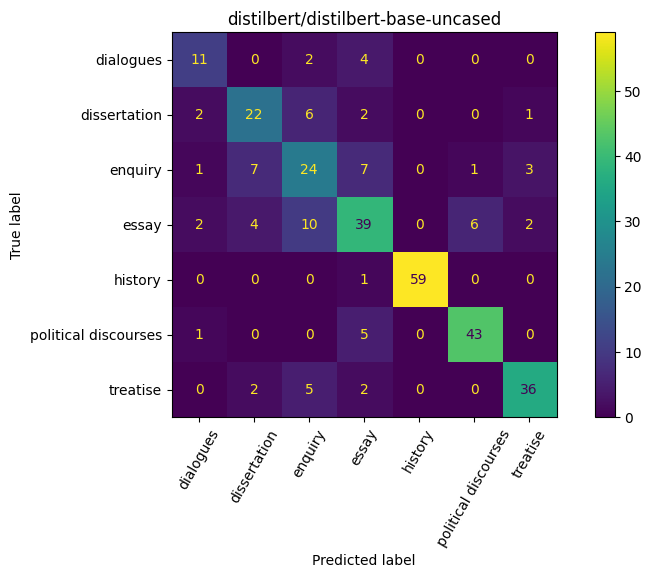

In [80]:
run_model('distilbert/distilbert-base-uncased', 
          data_random, 
          n_epochs=10, 
          print_examples=False, 
          save_suffix='random')

Map:   0%|          | 0/67 [00:00<?, ? examples/s]

Accuracy: 23.88


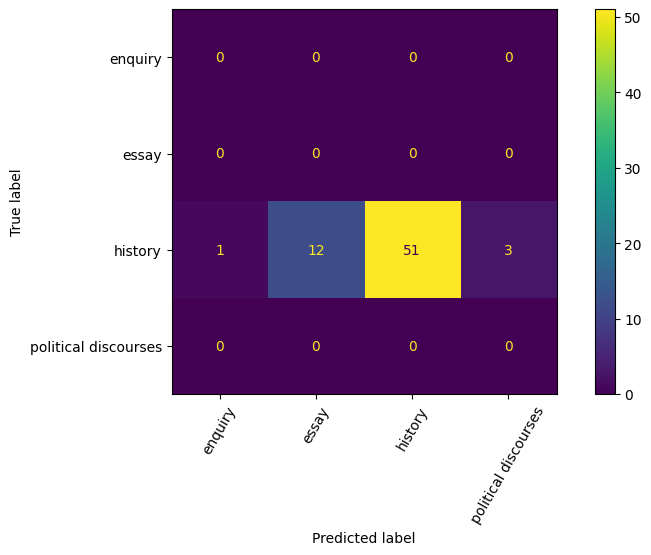

In [81]:
test_eh('models/distilbert/distilbert-base-uncased-finetuned-best-random')

In [99]:
run_many('distilbert/distilbert-base-uncased', n=15, n_epochs=10)

  0%|          | 0/15 [00:00<?, ?it/s]

Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.409500,1.053010,0.663430
2,0.896800,0.761533,0.747573
3,0.621700,0.723953,0.741100
4,0.421700,0.721995,0.737864
5,0.268800,0.655580,0.779935
6,0.152400,0.671823,0.783172
7,0.088200,0.735740,0.792880


Accuracy: 80.32
F1-score: 80.32


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.415500,1.094708,0.559871
2,0.852400,0.778519,0.724919
3,0.574800,0.690129,0.741100
4,0.346700,0.660399,0.779935
5,0.200000,0.754701,0.779935
6,0.108400,0.830830,0.757282


Accuracy: 77.42
F1-score: 77.42


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.394500,1.006804,0.647249
2,0.874900,0.824553,0.689320
3,0.609000,0.760954,0.724919
4,0.387200,0.788763,0.734628
5,0.234900,0.852226,0.715210


Accuracy: 75.48
F1-score: 75.48


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.405100,1.105375,0.588997
2,0.912000,0.886079,0.695793
3,0.646600,0.689816,0.763754
4,0.416000,0.706907,0.750809
5,0.260700,0.706328,0.757282


Accuracy: 74.19
F1-score: 74.19


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.367300,0.996078,0.631068
2,0.885100,0.819521,0.682848
3,0.658300,0.676095,0.744337
4,0.454900,0.637600,0.773463
5,0.298600,0.618596,0.779935
6,0.194700,0.642720,0.786408
7,0.108100,0.655020,0.809061


Accuracy: 77.74
F1-score: 77.74


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.392700,1.035744,0.653722
2,0.836100,0.756090,0.744337
3,0.565800,0.724197,0.754045
4,0.380100,0.644357,0.770227
5,0.236900,0.664597,0.779935
6,0.141500,0.697256,0.779935


Accuracy: 78.06
F1-score: 78.06


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.402300,1.147402,0.559871
2,0.879400,0.807108,0.689320
3,0.596500,0.749210,0.724919
4,0.396000,0.797937,0.718447
5,0.247000,0.776894,0.721683


Accuracy: 77.10
F1-score: 77.10


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.374300,1.103716,0.569579
2,0.869900,0.854239,0.663430
3,0.629400,0.798088,0.705502
4,0.427800,0.687102,0.773463
5,0.280400,0.711909,0.779935
6,0.169400,0.778649,0.750809


Accuracy: 74.19
F1-score: 74.19


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.399700,1.041809,0.624595
2,0.874700,0.827049,0.699029
3,0.614600,0.691089,0.744337
4,0.411400,0.659197,0.760518
5,0.264100,0.684751,0.773463
6,0.169200,0.659863,0.796117


Accuracy: 77.42
F1-score: 77.42


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.399400,1.022234,0.614887
2,0.891300,0.826136,0.705502
3,0.629300,0.787874,0.702265
4,0.428500,0.736133,0.731392
5,0.276100,0.762625,0.737864
6,0.158500,0.847507,0.731392


Accuracy: 73.87
F1-score: 73.87


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.382000,1.050321,0.647249
2,0.886400,0.756964,0.734628
3,0.620100,0.671142,0.747573
4,0.430300,0.583847,0.799353
5,0.274200,0.527593,0.812298
6,0.164100,0.553127,0.815534
7,0.101000,0.536585,0.825243


Accuracy: 80.65
F1-score: 80.65


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.410600,0.985460,0.624595
2,0.875800,0.736112,0.724919
3,0.607500,0.648881,0.757282
4,0.404300,0.658811,0.754045
5,0.247600,0.634497,0.779935
6,0.143000,0.607168,0.789644
7,0.080000,0.597211,0.805825
8,0.040200,0.715915,0.796117
9,0.027000,0.726991,0.809061


Accuracy: 80.32
F1-score: 80.32


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.414900,1.029217,0.605178
2,0.889600,0.814386,0.676375
3,0.643700,0.724220,0.715210
4,0.449100,0.729893,0.747573
5,0.276100,0.677616,0.757282
6,0.174100,0.802499,0.737864
7,0.105900,0.810936,0.766990


Accuracy: 77.42
F1-score: 77.42


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.414000,1.019874,0.624595
2,0.842800,0.837791,0.695793
3,0.540800,0.714413,0.731392
4,0.340400,0.708977,0.766990
5,0.206000,0.715893,0.786408
6,0.109900,0.756673,0.779935


Accuracy: 77.10
F1-score: 77.10


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.411700,0.996851,0.656958
2,0.875400,0.798343,0.702265
3,0.613800,0.732401,0.711974
4,0.410500,0.654106,0.763754
5,0.245600,0.642963,0.770227
6,0.149100,0.669141,0.789644
7,0.086900,0.742940,0.770227


Accuracy: 74.84
F1-score: 74.84
Mean accuracy:  77.07526881720429
Standard deviation for accuracy:  2.1606215195882


## Distilbert clean data

Map:   0%|          | 0/2324 [00:00<?, ? examples/s]

Map:   0%|          | 0/290 [00:00<?, ? examples/s]

Map:   0%|          | 0/291 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.444500,1.101424,0.593103
2,0.884400,0.928637,0.658621
3,0.596400,0.821690,0.700000
4,0.393500,0.840985,0.706897
5,0.253400,0.896631,0.727586


Accuracy: 79.73
F1-score: 79.73


0.7972508591065293

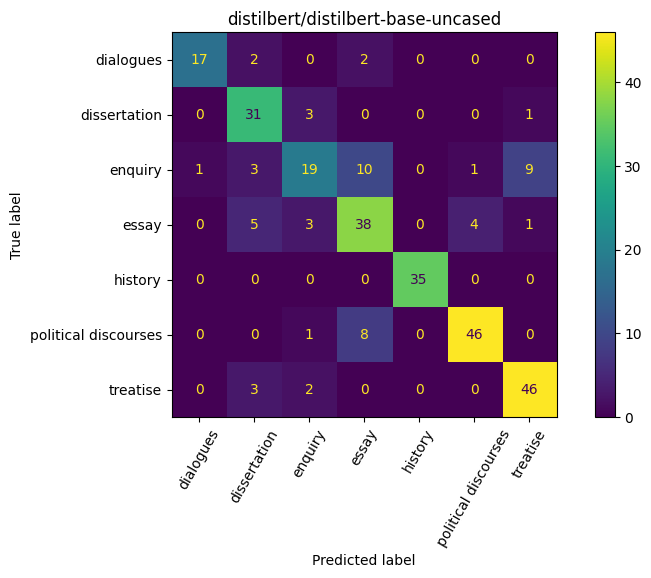

In [82]:
run_model('distilbert/distilbert-base-uncased', 
          data_automatic, 
          n_epochs=10, 
          print_examples=False, 
          save_suffix='automatic')

Map:   0%|          | 0/67 [00:00<?, ? examples/s]

Accuracy: 88.06


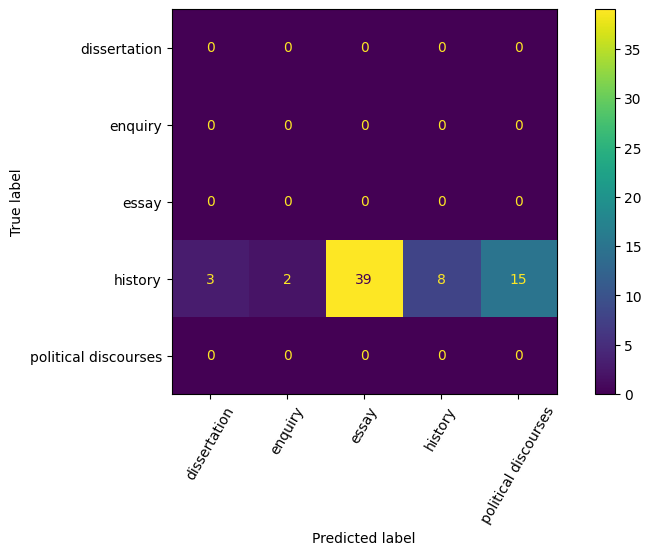

In [83]:
test_eh('models/distilbert/distilbert-base-uncased-finetuned-best-automatic')

## ECCObert

Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.165800,0.821437,0.686084
2,0.606500,0.690164,0.728155
3,0.329000,0.583847,0.809061
4,0.163900,0.584724,0.825243
5,0.085600,0.643498,0.831715


Accuracy: 81.61
F1-score: 81.61


0.8161290322580645

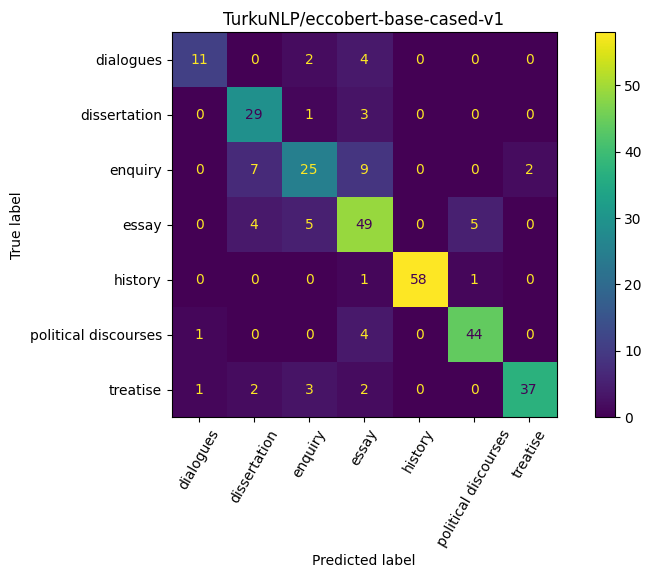

In [85]:
run_model('TurkuNLP/eccobert-base-cased-v1', data_random, n_epochs=10, save_suffix='random')

In [100]:
run_many('TurkuNLP/eccobert-base-cased-v1', n=15, n_epochs=10)

  0%|          | 0/15 [00:00<?, ?it/s]

Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.234000,0.766043,0.760518
2,0.632700,0.521525,0.831715
3,0.358900,0.466832,0.834951
4,0.194400,0.499192,0.847896
5,0.090500,0.516192,0.851133


Accuracy: 86.77
F1-score: 86.77


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.169300,0.812200,0.699029
2,0.571800,0.580505,0.815534
3,0.328600,0.550497,0.815534
4,0.170900,0.644999,0.805825
5,0.081000,0.733160,0.815534


Accuracy: 82.90
F1-score: 82.90


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.176800,0.711240,0.744337
2,0.605000,0.585546,0.786408
3,0.339200,0.509408,0.822006
4,0.175300,0.671192,0.770227
5,0.080300,0.622024,0.844660


Accuracy: 82.90
F1-score: 82.90


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.179600,0.759767,0.721683
2,0.603000,0.514579,0.818770
3,0.372100,0.444326,0.828479
4,0.193700,0.468768,0.847896
5,0.098900,0.531545,0.851133


Accuracy: 84.52
F1-score: 84.52


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.146800,0.750569,0.763754
2,0.584800,0.549386,0.792880
3,0.350300,0.430797,0.841424
4,0.190100,0.390215,0.877023
5,0.090900,0.484393,0.857605
6,0.036600,0.528362,0.877023


Accuracy: 84.52
F1-score: 84.52


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.172000,0.739475,0.747573
2,0.602200,0.497441,0.831715
3,0.345300,0.378448,0.870550
4,0.188400,0.463435,0.851133
5,0.093300,0.382253,0.880259


Accuracy: 82.58
F1-score: 82.58


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.171200,0.850955,0.695793
2,0.603500,0.674479,0.760518
3,0.345500,0.609819,0.809061
4,0.188500,0.629514,0.809061
5,0.092800,0.783190,0.799353


Accuracy: 82.90
F1-score: 82.90


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.160200,0.869585,0.673139
2,0.594600,0.645572,0.789644
3,0.337300,0.608342,0.799353
4,0.189900,0.618895,0.809061
5,0.091800,0.673373,0.828479


Accuracy: 80.00
F1-score: 80.00


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.163900,0.751534,0.711974
2,0.609700,0.544697,0.815534
3,0.362200,0.500733,0.818770
4,0.210800,0.502380,0.841424
5,0.097500,0.545433,0.854369


Accuracy: 84.19
F1-score: 84.19


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.163500,0.777638,0.741100
2,0.610400,0.579107,0.799353
3,0.340200,0.542897,0.809061
4,0.187700,0.516281,0.844660
5,0.090800,0.597413,0.831715
6,0.048900,0.617414,0.844660


Accuracy: 82.26
F1-score: 82.26


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.184300,0.813682,0.715210
2,0.646500,0.509312,0.812298
3,0.370700,0.408494,0.857605
4,0.206100,0.402647,0.880259
5,0.097000,0.455104,0.873786
6,0.042000,0.478767,0.873786


Accuracy: 83.55
F1-score: 83.55


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.202400,0.768962,0.705502
2,0.597900,0.490205,0.815534
3,0.351700,0.424732,0.831715
4,0.171100,0.456972,0.838188
5,0.081300,0.419091,0.870550
6,0.030700,0.549901,0.860841
7,0.018700,0.563118,0.864078


Accuracy: 86.45
F1-score: 86.45


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.198100,0.784640,0.728155
2,0.612000,0.521258,0.834951
3,0.341100,0.607382,0.799353
4,0.189700,0.583850,0.831715


Accuracy: 82.90
F1-score: 82.90


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.207600,0.806468,0.679612
2,0.618800,0.700243,0.757282
3,0.330100,0.486834,0.841424
4,0.161600,0.541488,0.841424
5,0.077200,0.623223,0.825243


Accuracy: 82.90
F1-score: 82.90


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.160300,0.722318,0.718447
2,0.587300,0.546097,0.802589
3,0.336700,0.452469,0.857605
4,0.178900,0.546208,0.841424
5,0.092300,0.640503,0.815534


Accuracy: 84.19
F1-score: 84.19
Mean accuracy:  83.56989247311829
Standard deviation for accuracy:  1.6084526409733486


Map:   0%|          | 0/67 [00:00<?, ? examples/s]

Accuracy: 14.93


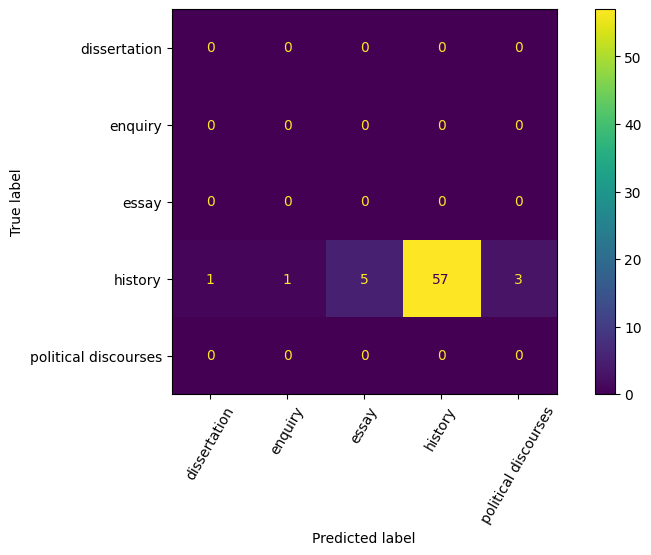

In [87]:
test_eh('models/TurkuNLP/eccobert-base-cased-v1-finetuned-best-random')

Map:   0%|          | 0/2324 [00:00<?, ? examples/s]

Map:   0%|          | 0/290 [00:00<?, ? examples/s]

Map:   0%|          | 0/291 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.210500,0.912292,0.634483
2,0.622400,0.806849,0.758621
3,0.343000,0.786398,0.765517
4,0.183200,0.741914,0.793103
5,0.094800,0.908181,0.779310
6,0.039300,1.068654,0.765517


Accuracy: 87.63
F1-score: 87.63


0.8762886597938144

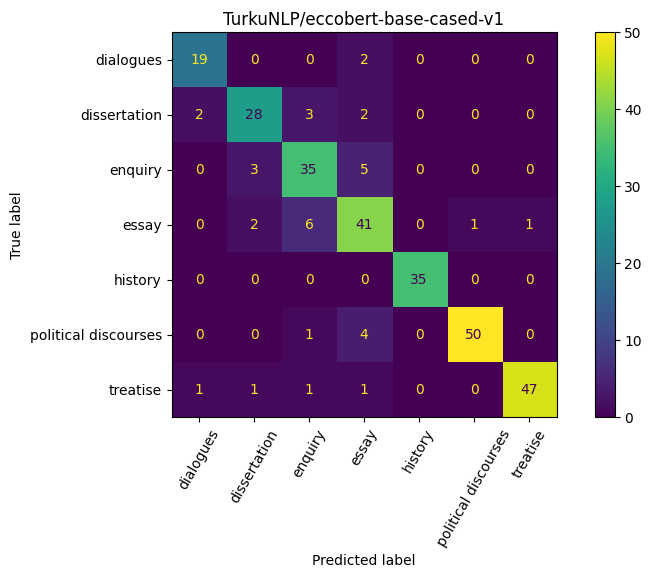

In [88]:
run_model('TurkuNLP/eccobert-base-cased-v1', data_automatic, n_epochs=10, save_suffix='automatic')

Map:   0%|          | 0/67 [00:00<?, ? examples/s]

Accuracy: 82.09


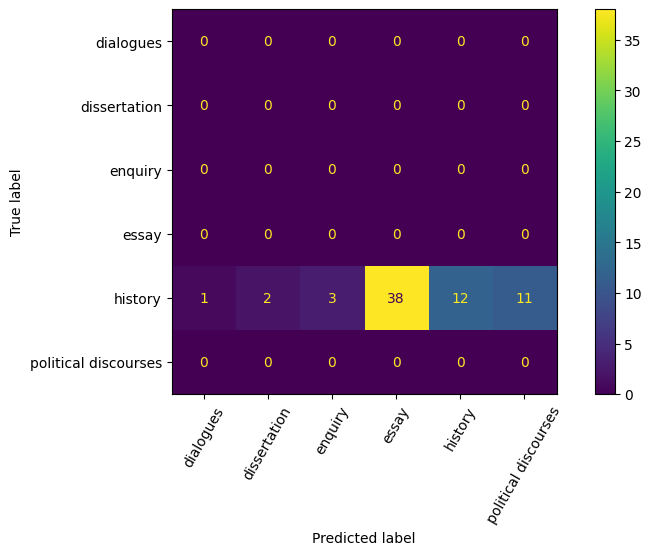

In [89]:
test_eh('models/TurkuNLP/eccobert-base-cased-v1-finetuned-best-automatic')

## xlm-roberta

Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.532700,1.131216,0.546926
2,1.012400,0.879002,0.663430
3,0.719400,0.773227,0.699029
4,0.512100,0.752490,0.741100
5,0.354100,0.734716,0.779935
6,0.251700,0.764529,0.776699
7,0.157800,0.789325,0.783172


Accuracy: 74.84
F1-score: 74.84


0.7483870967741936

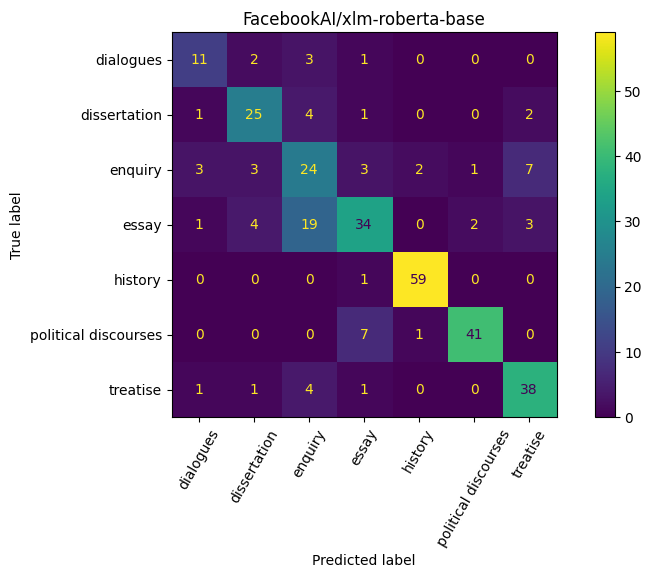

In [90]:
run_model('FacebookAI/xlm-roberta-base', data_random, n_epochs=10, save_suffix='random')

In [101]:
run_many('FacebookAI/xlm-roberta-base', n=15, n_epochs=10)

  0%|          | 0/15 [00:00<?, ?it/s]

Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.547300,1.042061,0.592233
2,0.983900,0.756305,0.718447
3,0.701900,0.670716,0.766990
4,0.493800,0.587473,0.805825
5,0.343300,0.691167,0.786408
6,0.228400,0.710302,0.792880


Accuracy: 76.45
F1-score: 76.45


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.453100,1.162377,0.511327
2,0.917400,0.798924,0.705502
3,0.638600,0.759306,0.728155
4,0.436300,0.718561,0.757282
5,0.306500,0.872069,0.731392
6,0.199600,0.922902,0.744337


Accuracy: 80.00
F1-score: 80.00


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.546200,1.126432,0.585761
2,1.051800,0.863385,0.660194
3,0.771800,0.794725,0.715210
4,0.542100,0.797737,0.724919
5,0.372400,0.766535,0.757282
6,0.253600,0.769637,0.754045
7,0.168300,0.947763,0.734628


Accuracy: 78.71
F1-score: 78.71


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.520900,1.143675,0.556634
2,1.046900,0.899166,0.676375
3,0.751400,0.735952,0.728155
4,0.525700,0.728836,0.754045
5,0.369000,0.679885,0.799353
6,0.253900,0.750905,0.792880
7,0.179300,0.809654,0.789644


Accuracy: 77.74
F1-score: 77.74


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.478500,1.054298,0.566343
2,0.947800,0.808169,0.692557
3,0.703300,0.669181,0.744337
4,0.486400,0.540529,0.825243
5,0.361400,0.554970,0.828479
6,0.216000,0.693059,0.815534


Accuracy: 76.45
F1-score: 76.45


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.511300,1.158002,0.527508
2,1.008900,0.849926,0.669903
3,0.715900,0.703501,0.744337
4,0.505500,0.581762,0.802589
5,0.322800,0.566968,0.805825
6,0.230900,0.606927,0.799353
7,0.139400,0.673598,0.802589


Accuracy: 78.06
F1-score: 78.06


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.567100,1.238099,0.530744
2,1.033100,0.925836,0.637540
3,0.740500,0.788779,0.711974
4,0.487600,0.764153,0.741100
5,0.321200,0.802847,0.734628
6,0.221300,0.862666,0.741100


Accuracy: 78.39
F1-score: 78.39


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.456700,1.191893,0.495146
2,0.941100,0.847150,0.679612
3,0.676500,0.782910,0.715210
4,0.466300,0.788639,0.731392
5,0.310400,0.750007,0.763754
6,0.201100,0.811065,0.773463
7,0.125500,0.950962,0.747573


Accuracy: 75.81
F1-score: 75.81


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.483000,1.005558,0.605178
2,0.926900,0.825093,0.663430
3,0.662500,0.735327,0.721683
4,0.477800,0.744563,0.715210
5,0.327600,0.784445,0.763754


Accuracy: 72.58
F1-score: 72.58


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.589700,1.083277,0.585761
2,1.061100,0.894387,0.631068
3,0.811400,0.883509,0.692557
4,0.591200,0.885364,0.695793
5,0.445400,0.770216,0.750809
6,0.299100,0.794786,0.750809
7,0.211700,0.882531,0.757282


Accuracy: 73.23
F1-score: 73.23


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.543000,1.078685,0.588997
2,0.998800,0.845237,0.679612
3,0.720300,0.751209,0.711974
4,0.501200,0.815531,0.734628
5,0.348200,0.603467,0.818770
6,0.227100,0.646063,0.802589
7,0.149300,0.715708,0.812298


Accuracy: 79.35
F1-score: 79.35


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.484300,1.037530,0.569579
2,0.943700,0.816702,0.656958
3,0.675600,0.671605,0.744337
4,0.466200,0.734107,0.750809
5,0.313200,0.772058,0.763754


Accuracy: 80.32
F1-score: 80.32


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.589000,1.186179,0.530744
2,1.047600,0.887760,0.656958
3,0.776300,0.731793,0.744337
4,0.576500,0.720821,0.737864
5,0.399000,0.805083,0.754045
6,0.279300,0.739450,0.763754


Accuracy: 76.77
F1-score: 76.77


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.557400,1.188450,0.521036
2,1.052900,0.899814,0.640777
3,0.764200,0.788603,0.705502
4,0.557700,0.709836,0.750809
5,0.399400,0.709860,0.773463
6,0.276300,0.703703,0.779935
7,0.178000,0.777021,0.789644
8,0.126300,0.809264,0.779935


Accuracy: 74.84
F1-score: 74.84


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.561100,1.004218,0.644013
2,0.967400,0.837712,0.682848
3,0.725300,0.825970,0.702265
4,0.537500,0.845801,0.744337
5,0.383000,0.833922,0.737864


Accuracy: 68.06
F1-score: 68.06
Mean accuracy:  76.45161290322581
Standard deviation for accuracy:  3.140815856680797


Map:   0%|          | 0/67 [00:00<?, ? examples/s]

Accuracy: 11.94


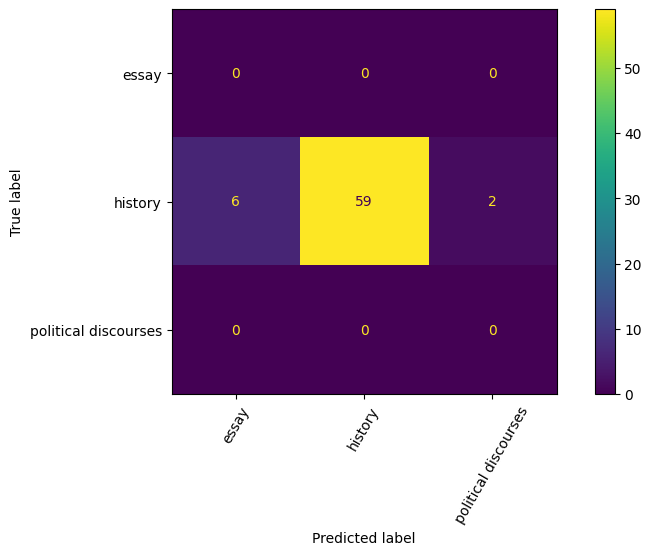

In [91]:
test_eh('models/FacebookAI/xlm-roberta-base-finetuned-best-random')

Map:   0%|          | 0/2324 [00:00<?, ? examples/s]

Map:   0%|          | 0/290 [00:00<?, ? examples/s]

Map:   0%|          | 0/291 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.540500,1.157926,0.517241
2,1.020000,0.977729,0.606897
3,0.744900,0.882061,0.679310
4,0.539300,0.890336,0.696552
5,0.372500,0.916539,0.727586


Accuracy: 74.57
F1-score: 74.57


0.7457044673539519

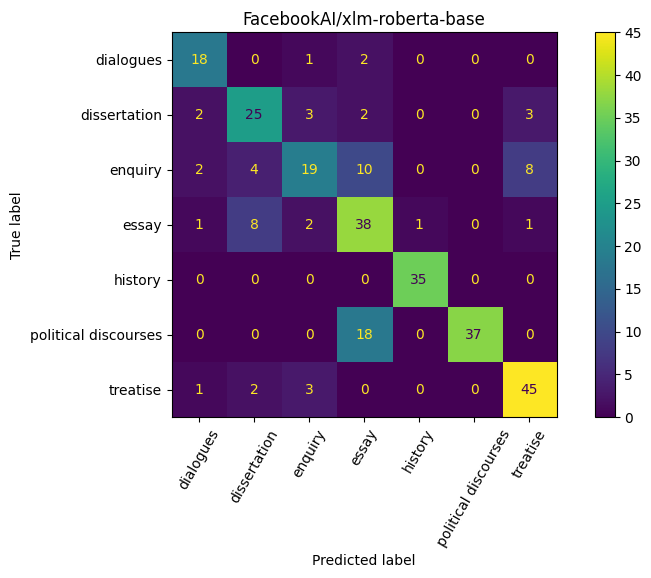

In [92]:
run_model('FacebookAI/xlm-roberta-base', data_automatic, n_epochs=10, save_suffix='automatic')

Map:   0%|          | 0/67 [00:00<?, ? examples/s]

Accuracy: 64.18


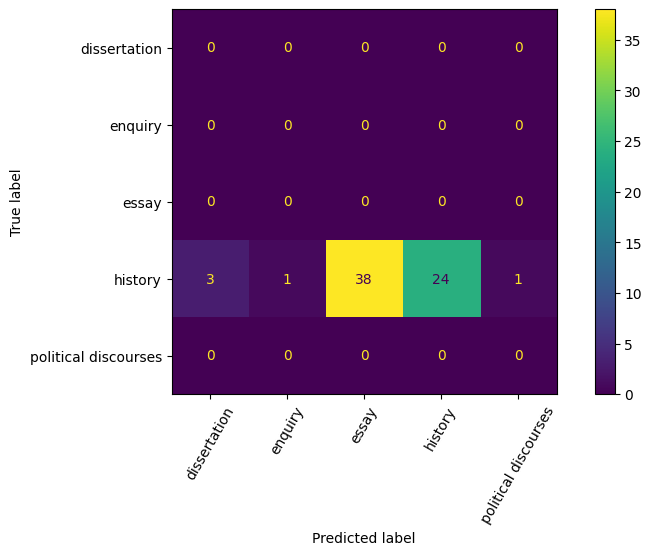

In [93]:
test_eh('models/FacebookAI/xlm-roberta-base-finetuned-best-automatic')

## Logits

Map:   0%|          | 0/67 [00:00<?, ? examples/s]

TEST ACCURACY:  0.582089552238806
Sure: 36, unsure: 31


/tmp/ipykernel_4237/1667133791.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)


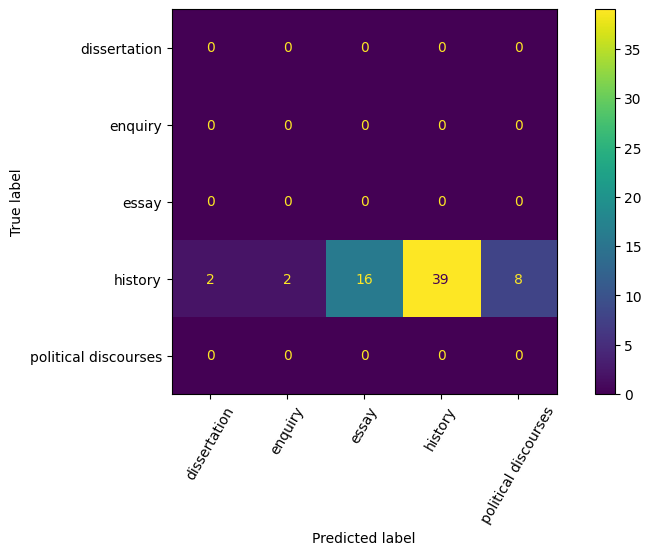

In [35]:
model_name = 'models/distilbert/distilbert-base-uncased-finetuned/checkpoint-775'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)

ds = load_dataset('json', data_files='hume_json/essays_in_history.json')

model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                            num_labels=len(id2label), 
                                                            id2label=id2label, 
                                                            label2id=label2id).to(device)

tokenized_dataset = ds.map(preprocess_function, batched=True)

# testing

correct = 0
samples = 0

sure = 0
unsure = 0

y_test = []
pred = []

for line in tokenized_dataset['train']:
    
    text = line['text']
    label = line['labels']
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    
    with torch.no_grad():
        logits = model(**inputs).logits
    
    predicted_class_id = logits.argmax().item()
    probs = F.softmax(logits) 
#     model.config.id2label[predicted_class_id]

#     print(max(probs[0]))

    if max(probs[0]) >= 0.8:
        sure +=1
    else:
        unsure += 1
    
    if label == predicted_class_id:
        correct += 1
    
    samples += 1

    y_test.append(label)
    pred.append(predicted_class_id)

print('TEST ACCURACY: ', correct/samples)

print(f'Sure: {sure}, unsure: {unsure}')

classes = ['dialogues', 'dissertation', 'enquiry', 'essay', 'history', 'political discourses', 'treatise']

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)

left = min(min(y_test), min(pred))
right = max(max(y_test), max(pred))
ax.xaxis.set_ticks([i for i in range(0, right+1-left)], classes[left:right+1], rotation=60)
ax.yaxis.set_ticks([i for i in range(0, right+1-left)], classes[left:right+1])